In [1]:
using Clustering, PyPlot
using TextAnalysis
using JLD2
using Statistics
using XLSX
using CSV
using DataFrames
using Dates
using LinearAlgebra
using StatsBase
using MultivariateStats
using Random

In [39]:
include("../src/utill.jl")

sel_top (generic function with 1 method)

In [3]:
new_df = XLSX.readxlsx("../data/Data-Spring/covid-en.xlsx")["Sheet1"]
stop_ind = new_df.dimension.stop;

en_1 = DataFrame(new_df["A2:$stop_ind"],  [:retweet_count, :favorite_count, 
        :created_at, :text, :id_str, 
        :lang])
mask_tmp = ones(Bool, length(en_1.id_str)) 
insert!(en_1, 7, mask_tmp, :tind)


new_df = XLSX.readxlsx("../data/Data-Winter/covid-en.xlsx")["Sheet1"]
stop_ind = new_df.dimension.stop;

en_2 = DataFrame(new_df["A2:$stop_ind"],  [:retweet_count, :favorite_count, 
        :created_at, :text, :id_str, 
        :lang]);

mask_tmp = zeros(Bool, length(en_2.id_str)) 
insert!(en_2, 7, mask_tmp, :tind)

min_dim = minimum([length(en_1.tind), length(en_2.tind)])

df = append!(en_1[1:min_dim, :], en_2[1:min_dim, :]);

# df = df[shuffle(1:length(df.favorite_count)), :]

In [4]:
size(df)

(195532, 7)

## Preprocessing:

In [5]:
function preprocess_corp(data)
    data_preprocessed = replace.(data, r"http\S+" => s"")
    data_preprocessed = replace.(data_preprocessed, r"\S+.com" => s"")
    data_preprocessed = replace.(data_preprocessed, r"resulting" => s"")
    data_preprocessed = replace.(data_preprocessed, r"RESULTING" => s"")
    data_preprocessed = replace.(data_preprocessed, r"#resulting" => s"")
    data_preprocessed = replace.(data_preprocessed, r"@\S+" => s"")
    data_preprocessed = replace.(data_preprocessed, r"&amp" => s"")
    data_preprocessed = replace.(data_preprocessed, r"RT\S+" => s"");
    data_preprocessed = replace.(data_preprocessed, contractions...);

    crps_tmp = Corpus(StringDocument.(deepcopy(data_preprocessed)));

    remove_case!(crps_tmp)
    prepare!(crps_tmp, strip_punctuation)
    prepare!(crps_tmp, strip_numbers)
    prepare!(crps_tmp, strip_articles)

    prepare!(crps_tmp, strip_pronouns)
    prepare!(crps_tmp, strip_prepositions)
    prepare!(crps_tmp, strip_definite_articles)
    prepare!(crps_tmp, strip_indefinite_articles)

    prepare!(crps_tmp, strip_stopwords)
    prepare!(crps_tmp, strip_non_letters)
    remove_words!(crps_tmp, ["don", "re", "ve", "ll", "covid", "coronavirus", "via"])
    stem!(crps_tmp)
    prepare!(crps_tmp, strip_whitespace)
    update_lexicon!(crps_tmp)
    return crps_tmp
end

preprocess_corp (generic function with 1 method)

In [6]:
crps = preprocess_corp(df[:,4])

A Corpus with 195532 documents:
 * 195532 StringDocument's
 * 0 FileDocument's
 * 0 TokenDocument's
 * 0 NGramDocument's

Corpus's lexicon contains 107438 tokens
Corpus's index contains 0 tokens

In [7]:
# crps_1 = preprocess_corp(df[df.tind,4])
# crps_2 = preprocess_corp(df[.!df.tind,4]);

In [8]:
# Create a vector from merged corpus: 

lexicone_vect = lexicon(crps)

n_max = 300
pairs = sort(collect(lexicone_vect), by=x->x[2], rev=true)[1:n_max]
terms = [i[1] for i in pairs];

In [9]:
# # Create a vector from different datasets: 

# lexicone_vect_1 = lexicon(crps_1)
# lexicone_vect_2 = lexicon(crps_2)

# n_max = 200
# pairs_1 = sort(collect(lexicone_vect_1), by=x->x[2], rev=true)[1:n_max]
# terms_1 = [i[1] for i in pairs_1]

# pairs_2 = sort(collect(lexicone_vect_2), by=x->x[2], rev=true)[1:n_max]
# terms_2 = [i[1] for i in pairs_2]

# terms = unique([terms_1 ; terms_2])

# length(terms)

In [10]:
terms[1:20]

20-element Array{String,1}:
 "vaccin"
 "peopl"
 "death"
 "test"
 "pandem"
 "health"
 "time"
 "trump"
 "die"
 "help"
 "day"
 "report"
 "virus"
 "posit"
 "hospit"
 "news"
 "lockdown"
 "home"
 "live"
 "countri"

In [11]:
m = DocumentTermMatrix(crps, terms)

A 195532 X 300 DocumentTermMatrix

In [12]:
D = convert.(Float64, dtm(m, :dense)')

# D[:,df.tind] = D[:,df.tind] ./ sum(D[:,df.tind])
# D[:,.!df.tind] = D[:,.!df.tind] ./ sum(D[:,.!df.tind]);

In [13]:
# PCA:

# M = fit(PCA, D; maxoutdim=5)
# Yte = MultivariateStats.transform(M, D);

In [14]:
# Independent Component Analysis:

# M = fit(ICA, D, 6)
# Yte = MultivariateStats.transform(M, D)

In [15]:
# n_clusters = 5
# cl = kmeans(Yte, n_clusters, tol=10^-8);
# cl_assignments = cl.assignments;

In [16]:
# vars = (Yte, cl_assignments, M, D)
# JLD2.@save "../data/tmp_files/en.jld" vars

In [17]:
JLD2.@load "../data/tmp_files/en.jld" vars
(Yte, cl_assignments, M, D) = vars ;

In [18]:
cvals= log.(1 .+ df.favorite_count)
avals = 1 .+ df.retweet_count ; avals = log.(avals); avals = avals .- (minimum(avals) - 0.1) ; avals = avals ./ maximum(avals)
avals_t = [df.tind[i] == 1 ? plt.cm.Blues_r(avals[i]) : plt.cm.Reds_r(avals[i]) for i in eachindex(df.tind)];

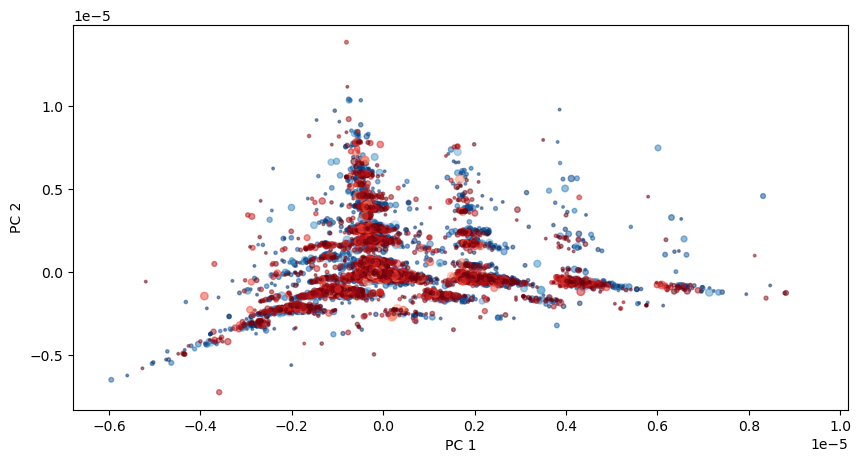

In [19]:
fig, ax= plt.subplots(1,1, figsize=(10,5))

ax.scatter(Yte[4,:], Yte[3,:], alpha=0.5, s=5.0.*cvals, c=avals_t, rasterized=true, label="April") # 3 / 4 

# ax.set_xlim(-0.4e-5, 0.8e-5)
# ax.set_ylim(-0.4e-5, 0.5e-5)

# ax.legend(loc="lower right", frameon=false ) # 

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

# ax.set_xticks([])
# ax.set_yticks([]);

# ax.set_xticklabels([])
# ax.set_yticklabels([]);

# ax.set_axis_off()

# Select Tweets: 

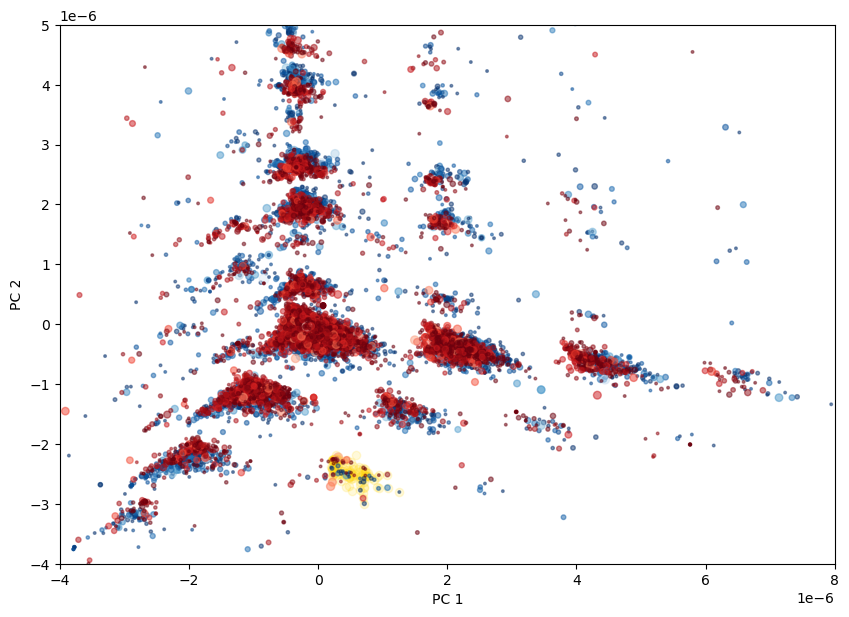

In [29]:
d1, d2 = 4, 3
msk1 = 0.02e-5 .< Yte[d1,:] .< 0.15e-5
msk2 = -0.3e-5 .< Yte[d2,:] .< -0.20e-5

msk = msk1 .* msk2

fig, ax= plt.subplots(1,1, figsize=(10,7))
ax.scatter(Yte[d1,:], Yte[d2,:], alpha=0.5, s=5.0.*cvals, c=avals_t, rasterized=true, label="April") # 3/4

ax.scatter(Yte[d1,msk], Yte[d2,msk], rasterized=true, color="gold", alpha=0.15, zorder=-10) 

ax.set_xlim(-0.4e-5, 0.8e-5)
ax.set_ylim(-0.4e-5, 0.5e-5)

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

# ax.set_xticks([])
# ax.set_yticks([]);

# ax.set_xticklabels([])
# ax.set_yticklabels([]);

# ax.set_axis_off()

In [30]:
d_tmp = df[msk,:]
d_tmp = d_tmp[sortperm(d_tmp.favorite_count, rev=true)[1:20], [2,3,4,5]] # https://twitter.com/Angry_Voice/status/1250421707921211398

,favorite_count,created_at,text
,Any,Any,Any
1,2359,2020-12-10T17:13:52,"The man who sent 1000s to #COVID death in nursing homes learned about “putting people first” from Ted Kennedy, a man who abandoned a woman to her death after he crashed their car into a pond. Those Cuomo victims &amp; Mary Jo Kopechne can’t comment, but we still can. #disgusting https://t.co/HJkuEbrGTy"
2,523,2020-12-11T11:38:59,"BREAKING: A new single-day record of 3,110 U.S. #COVID deaths were reported on Thurs, 12/10; breaking the previous day’s record of 3,102 deaths.\n \nThere were 229,928 new cases on Thurs, also a new record.\n\n292,954 people have died of #COVID-19 in the U.S."
3,82,2020-12-13T07:31:47,No Data Available\n♦️Farmer Suicides\n♦️Deaths and Job Losses of Migrant Workers\n♦️Deaths of COVID-19 Front Line Workers\n♦️Closure of MSMEs During Lockdown &amp; after Demonitisation\n♦️Number of RTI Activists Killed\nAnd the BJP Government wants people to trust them.😡\n#ThePMDoesNotCare
4,57,2020-04-12T00:34:37,"South Korea (50m) vs UK (60m people) covid stats.\nSouth Korea: 200 deaths, spread stabilized.\nUK: 9000 deaths, spread out of control.\n\nSK citizens pay taxes and get protected. \n\nhttps://t.co/WmkQShSyxM\nhttps://t.co/e58kNvHwjv\n\nUK PM is an infection vector https://t.co/crwuruq7Bd https://t.co/5f6rX18qD6"
5,25,2020-12-14T04:14:22,Every day for the last week as many people died from #Covid_19 each day as the total deaths of Sept 11 terrorist attacks.\n\nEvery single #Covid death is blood on Trump's hands. He knew and did nothing.\n\nTrump is killing more Americans than Osama Bin Laden.\n\nTrump is a murderer.
6,21,2020-04-14T17:28:58,"Conservatives again. Most of the deaths are people who will likely die soon anyway so f#*k them. Reopen all business.\nTory MP notes 'most' pandemic deaths are in care homes, asks if it's time to reopen economy\nhttps://t.co/d4ooGSOQyf https://t.co/2k0suJdR4x"
7,8,2020-04-15T21:54:43,"@YAlabaster @JollyFoxtrotSix @philipneumann @TomHShoemaker @drbogenbroom1 @IngrahamAngle Over 28,000 people have died from COVID-19 in about 2 months in the US. What do you think the numbers would be without social distancing? The death rate for the flu is 0.1%. The death rate for COVID-19 is 3%."
8,7,2020-12-14T09:06:08,@PMFight @MaxMcKelly @MillerStream People die. The day they are born they are dying. There is risk of death in nearly everything you do every single day. The risk of death by CoVid-19 is very low. Facts.
9,6,2020-04-12T12:11:16,"#CoronavirusPandemic #Europe Confirmed deaths due to COVID-19 per million people. Currently, #Greece is having less deaths than: https://t.co/kwAWb2Nl86"


In [31]:
tw_t1 = PyPlot.imread("../plots/22.png");
tw_t2 = PyPlot.imread("../plots/11.png");

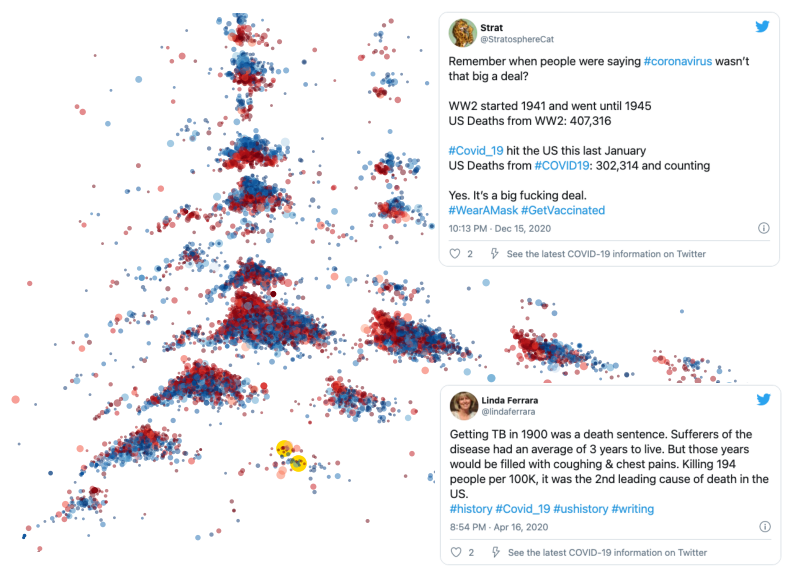

In [32]:
d1, d2 = 4, 3

# PCA 30 components, 4 and 3 dims

id_arr = parse.(Int64, df.id_str )
# tw1 = 1251181407042514944  
# tw2 = 1337437329695371272 

tw1 = 1338955328864411649  
tw2 = 1250860028896124928 

perm_ind = shuffle(1:length(df.id_str))

fig, ax= plt.subplots(1,1, figsize=(10,7))
ax.scatter(Yte[d1,perm_ind], Yte[d2,perm_ind], alpha=0.5, s=6.0 .* cvals[perm_ind], c=avals_t[perm_ind], edgecolors="none", linewidths=0.0, rasterized=true, label="April") # 3/4

ax.scatter(Yte[d1,id_arr .== tw1], Yte[d2,id_arr .== tw1], s=100, marker = "o", rasterized=true, edgecolor="gold", color="gold", alpha=1, lw=2, zorder=-10) 
ax.scatter(Yte[d1,id_arr .== tw2], Yte[d2,id_arr .== tw2], s=100, marker = "o", rasterized=true, edgecolor="gold", color="gold", alpha=1, lw=2, zorder=-10) 

ax2 = fig.add_axes([0.55,0.50,0.35,0.4]) # April 
ax3 = fig.add_axes([0.55,0.07,0.35,0.3])
ax2.set_axis_off()
ax3.set_axis_off()
ax2.imshow(tw_t1)
ax3.imshow(tw_t2)

ax.set_xlim(-0.4e-5, 0.8e-5)
ax.set_ylim(-0.4e-5, 0.5e-5)

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_axis_off()

# fig.savefig("../plots/3d-samples-en-2.png", bbox_inches = "tight", dpi=700)

In [33]:
# fig, ax = plt.subplots(1,1, figsize=(7,5))

# clst_tmp = unique(cl_assignments)

# for (ind, val) in enumerate(clst_tmp)
#     cl_mask = cl_assignments .== val
#     ax.scatter(Yte[1,cl_mask], Yte[2,cl_mask], s=3, color=plt.cm.hsv(ind/length(clst_tmp)), alpha=0.8, ) 
# end

# ax.set_xlabel("PC 1")
# ax.set_ylabel("PC 2")

# ax.set_xticklabels([])
# ax.set_yticklabels([]);

# # ax.set_axis_off()

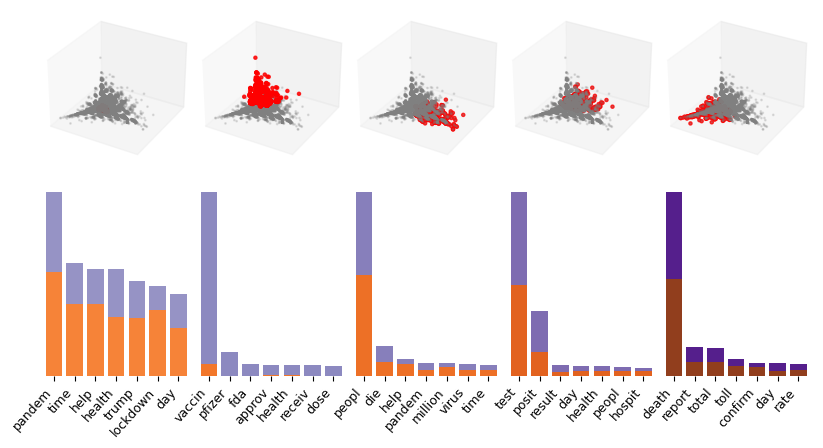

In [34]:
# Oranges - Begining 
# Purples - End

figure = make_plots(Yte, D, terms, cl_assignments, df.tind, df.retweet_count, dims=(4,3,1));

In [35]:
# figure.savefig("../plots/words-clusters-en.pdf", bbox_inches = "tight",) # dpi=500

In [38]:
size(sorted_top, 1)

250

In [41]:
sorted_top = sel_top(df, cl_assignments)

,clust_id,favorite_count,created_at,text
,Int64,Any,Any,Any
1,1,23320,2020-04-15T23:50:34,I asked my students (for extra credit) to select one COVID-19 artifact that they would suggest to a historian 100 years from now for an exhibit. The results are moving and heartbreaking. The only rule was they couldn't say anything medical since that would be easy (masks etc)
2,1,19609,2020-04-17T07:06:20,"Covid-19 crisis:\n\nIndia sending Hydroxychloroquine to 55 nations\n\nNow, Pakistan has asked India to help by providing Hydroxychloroquine medicine\n\n5 days ago, 3 civilians, including child &amp; woman, killed in J&amp;K's Kupwara due to shelling by Pakistan Army\n\nDoes Pak deserve humanity?"
3,1,18009,2020-04-13T22:08:01,Inside coronavirus briefing President Trump is having reporters watch campaign style montage praising his handling of coronavirus. #Covid_19 https://t.co/Idq26FKYqQ
4,1,16326,2020-04-13T06:56:58,"A Covid-19 patient was booked by Police after he spat on a nurse treating him at hospital in Tamil Nadu's Tiruchirappalli\n\nHe also removed his mask &amp; threw it at the nurse, enraging the hospital staff &amp; other patients.\n\nHe's from the 'single source' event.\n\nWhat's single source ?"
5,1,14509,2020-04-14T15:59:41,"Every time a hospital admits, discharges, or loses a patient to Covid-19, they are compensated 15% more according to the CARES ACT, SEC 4409. \n\nNYC was facing a hospital budget crisis and you fixed it for them. They are inflating all of their #coronavirus numbers. https://t.co/sH1N18lpfB"
6,1,13117,2020-04-12T01:19:37,"He wasn’t yet 20 when snipers’ bullets zipped past his head in Germany.\n\nHe stood guard at Nuremberg, hearing of the Nazi atrocities.\n\nShocks. Aftershocks.\n\nEmilio J. DiPalma died at 93 of the coronavirus.\n\nThere’ll be no funeral.\nPlease remember him.\n\n#COVID19 #Coronavirus https://t.co/LC93hSDmpi"
7,1,11235,2020-04-15T06:34:54,"It is with great sadness we announce that another member of our healthcare family, student nurse Ade Raymond, has sadly died from COVID-19. https://t.co/BHzZIUbnaM"
8,1,11132,2020-04-11T21:00:34,Liberal Treated With Hydroxychloroquine Hopes He Still Dies Of COVID-19 To Prove Trump Is Stupid https://t.co/z273EIQB1K
9,1,10049,2020-04-11T17:08:33,This is an extraordinary calamity. A mark in U.S. history that will never be forgotten. The historical record matters. So we assembled a large collection of these emails and have posted them here online. Here they are for you all to read. Click on link: https://t.co/HRyAhgMFWW https://t.co/LV1ZgTdhqk


In [43]:
# XLSX.writetable("../data/upload/Data-Clusters-Equal/sorted-en.xlsx", collect(DataFrames.eachcol(sorted_top)), DataFrames.names(sorted_top))